In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h, c, e
import os
from PIL import Image
import numpy as np
import pandas as pd

def process_phsp_file(filename):
    with open(filename, 'r') as file:

        # Initialize lists to store extracted data
        energies = []
        positions = []
        direction_cosines = []
        
        for line in file:
            # Split the line into columns
            columns = line.split()  # Assuming space-separated values

            # Check if the line corresponds to a photon
            if columns[7] == '-22':  
                energy = float(columns[5])  # Energy in MeV
                position = (float(columns[0]), float(columns[1]), float(columns[2]))  # Positions X, Y, Z
                direction_cosine = (float(columns[3]), float(columns[4]), float(columns[8]))  # Direction cosines X, Y, Z

                energies.append(energy)
                positions.append(position)
                direction_cosines.append(direction_cosine)

    # Here you can process the extracted data further or save it, etc.
    return energies, positions, direction_cosines


def Mev_to_wavelength(energy_Mev):
    # Convert energy from eV to wavelength in meters
    energy_joules = 10**6 * energy_Mev * e
    wavelength_m = h * c / energy_joules
    return wavelength_m

def create_histogram(data, bins):
    # Accumulate the photons in a 2D histogram
    # Assuming data contains x, y positions
    histogram, _, _ = np.histogram2d(data[:,1], data[:,2], bins=bins)
    return histogram

def simulate_camera(histogram, intrinsic_params, extrinsic_params):
    # Simulate the virtual camera recording the photons
    # This is a placeholder function; you need to implement the camera model
    # using the intrinsic and extrinsic parameters provided
    # This function should project the 2D histogram onto the camera sensor
    camera_image = np.zeros_like(histogram)  # Placeholder for the camera image
    return camera_image


optical_phasespace_ref_slice01_mus_689_mua_011


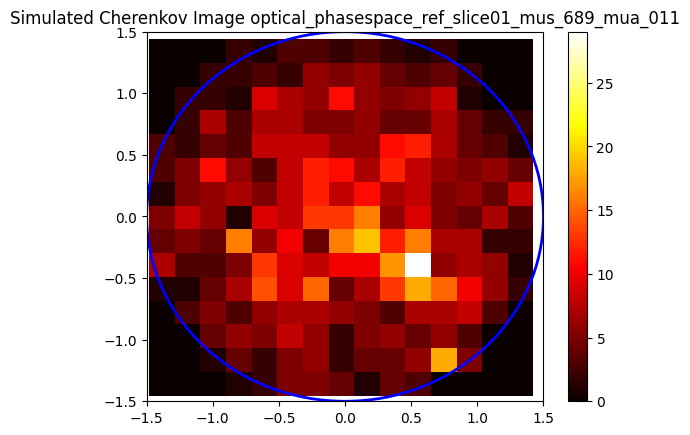

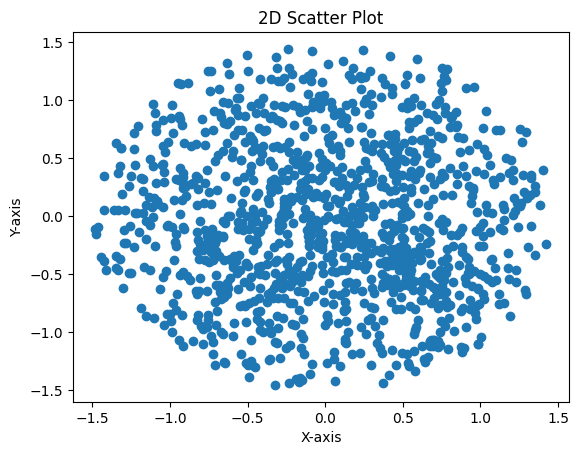

optical_phasespace_ref_slice01_mus_689_mua_061


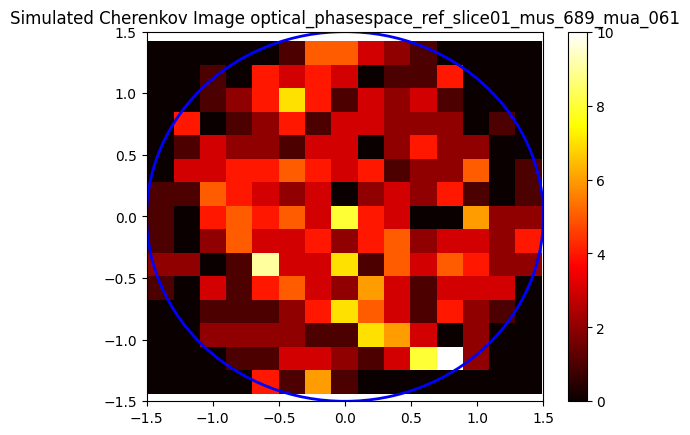

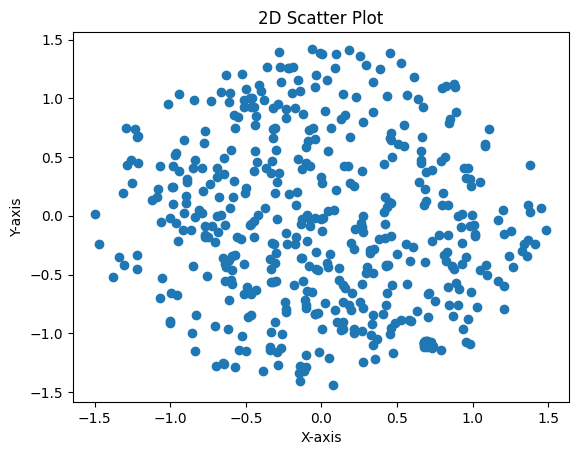

optical_phasespace_ref_slice01_mus_1089_mua_04


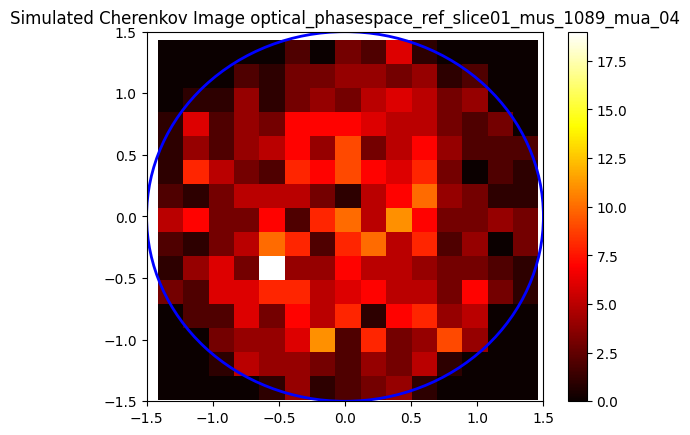

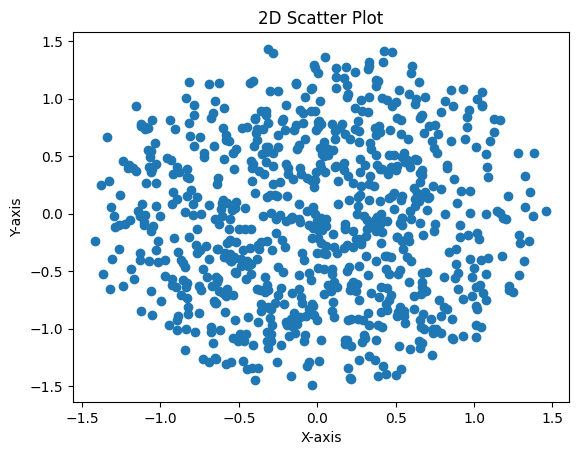

optical_phasespace_ref_slice01_mus_1089_mua_011


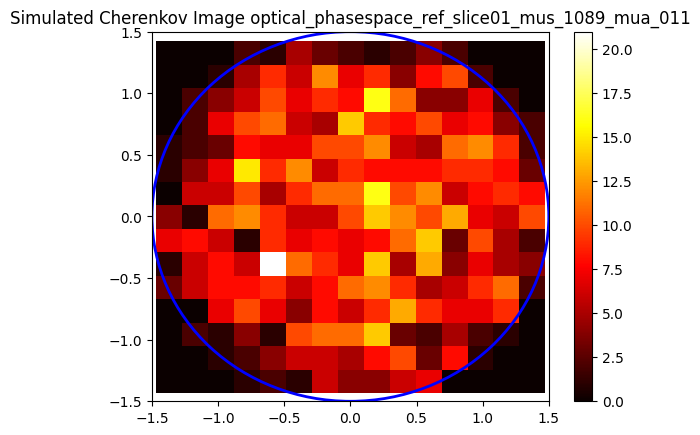

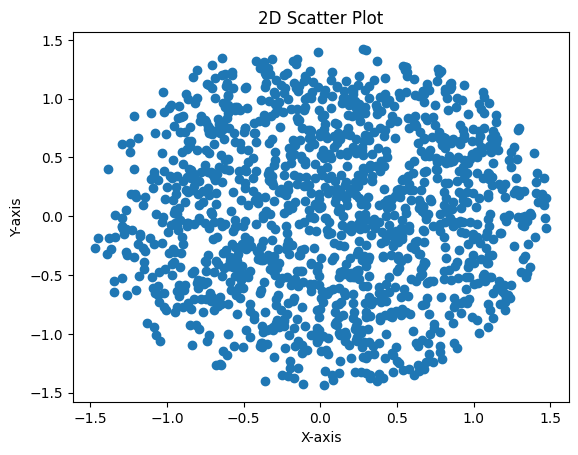

optical_phasespace_ref_slice01_mus_689_mua_04


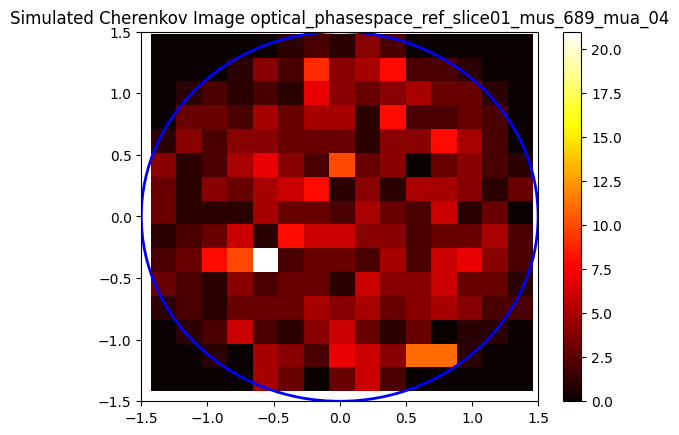

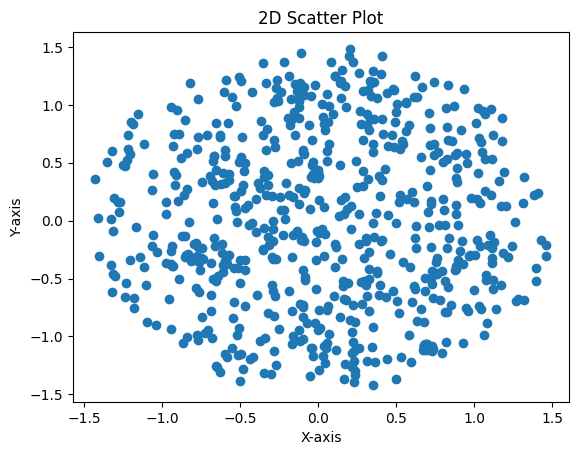

optical_phasespace_ref_slice01_mus_2035_mua_061


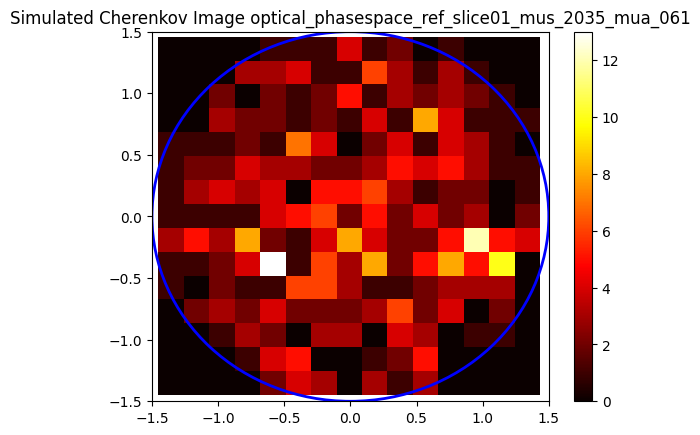

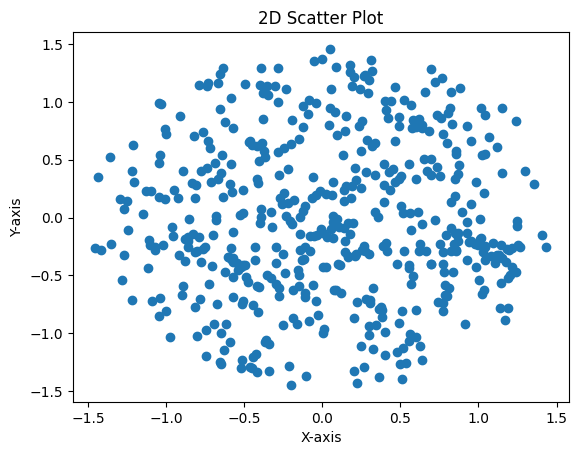

optical_phasespace_ref_slice01_mus_2035_mua_04


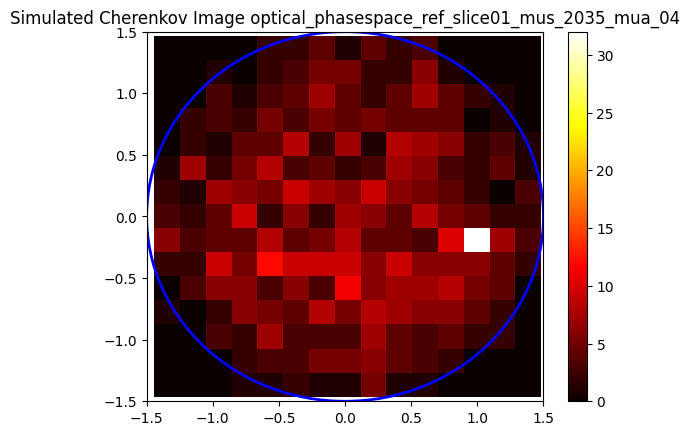

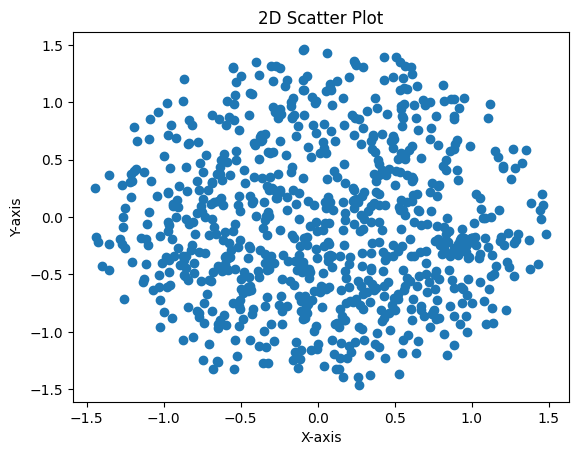

optical_phasespace_ref_slice01_mus_2035_mua_011


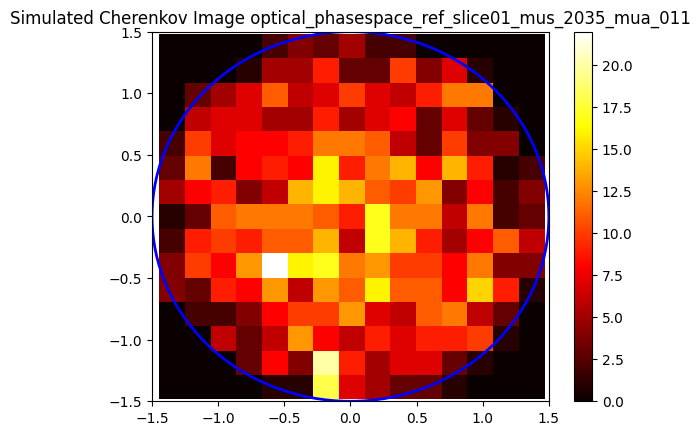

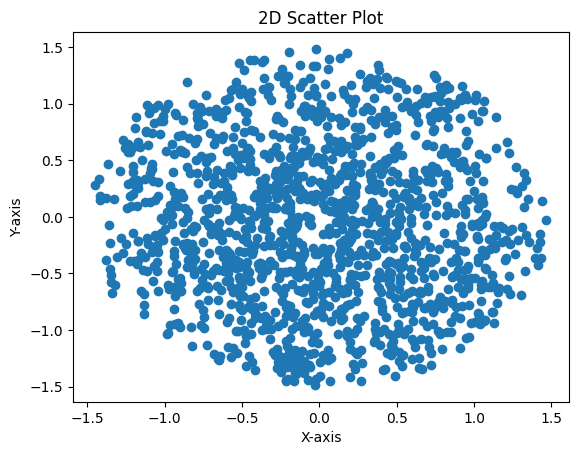

optical_phasespace_ref_slice01_mus_1089_mua_061


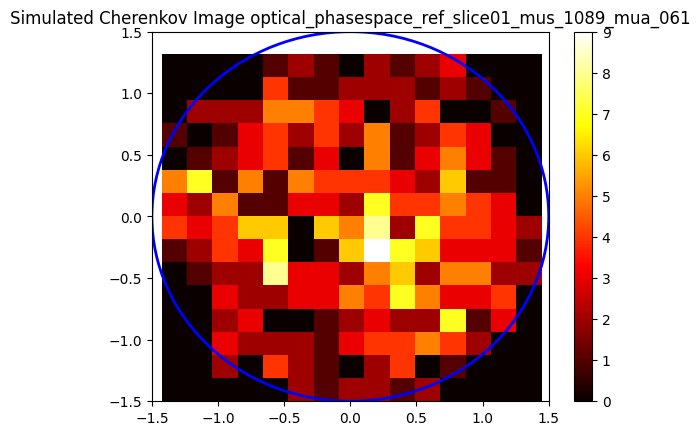

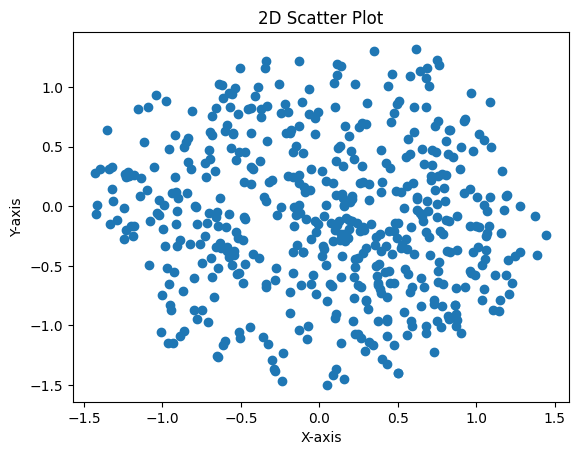

In [6]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the directory containing the files
directory = "/Applications/topas/OpticalPhantomExperiment/Output/"

# Initialize a list to store filenames
filenames = []

# Main workflow
for item in os.listdir(directory):
    if item.startswith("optical_phasespace_ref_slice01") and item.endswith(".phsp"):
        filenames.append(item)

# Loop through each filename
for filename in filenames:
    phantomname = filename.split(".")[0]
    print(phantomname)
    fullfilename = os.path.join(directory, filename)

    # Get out energies, positions, and direction_cosigns
    energies, positions, direction_cosines = process_phsp_file(fullfilename)

    # Convert energy to wavelength
    wavelengths = 10**9 * np.array([Mev_to_wavelength(energy) for energy in energies])

    # Filter energies and positions based on wavelengths between 550 and 800 nm
    filtered_indices = np.where((wavelengths >= 0) & (wavelengths <= 1000))[0]
    filtered_energies = []
    filtered_positions = []

    for f in filtered_indices.tolist():
        filtered_energies.append(energies[f]) 
        filtered_positions.append(positions[f])

    # Calculate the histogram for filtered positions
    bins = 15
    filtered_histogram, xedges, yedges = np.histogram2d(
        [row[0] for row in filtered_positions],  # x positions
        [row[1] for row in filtered_positions],  # y positions
        bins=[bins, bins]  # specifying the bin size for both dimensions
    )

    # Plot and save the image (uncomment if you want to display images)
    # Plot the histogram
    plt.hist2d(
        [row[0] for row in filtered_positions],  # x positions
        [row[1] for row in filtered_positions],  # y positions
        bins=[bins, bins],  # specifying the bin size for both dimensions
        cmap='hot'
    )
    plt.colorbar()
    plt.title("Simulated Cherenkov Image " + phantomname)
    
    # Draw a circle
    circle = plt.Circle((0, 0), 1.5, color='blue', fill=False, linewidth=2)
    plt.gca().add_artist(circle)

    # Set x and y axis limits
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    
    plt.show()

    # Uncomment the following lines if you want to save the images
    # Convert the numpy array to a PIL image
    image = Image.fromarray(np.uint16(filtered_histogram))
    
    # Save the image
    output_path = os.path.join("/Applications/topas/OpticalPhantomExperiment/OutputCherenkovImages/",
                               'Cherenkov_image' + phantomname + '.tif')
    image.save(output_path)

    # Create a figure and axis
    plt.figure()
    plt.scatter( [row[0] for row in filtered_positions], [row[1] for row in filtered_positions])

    # Add labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('2D Scatter Plot')

    # Display the plot
    plt.show()

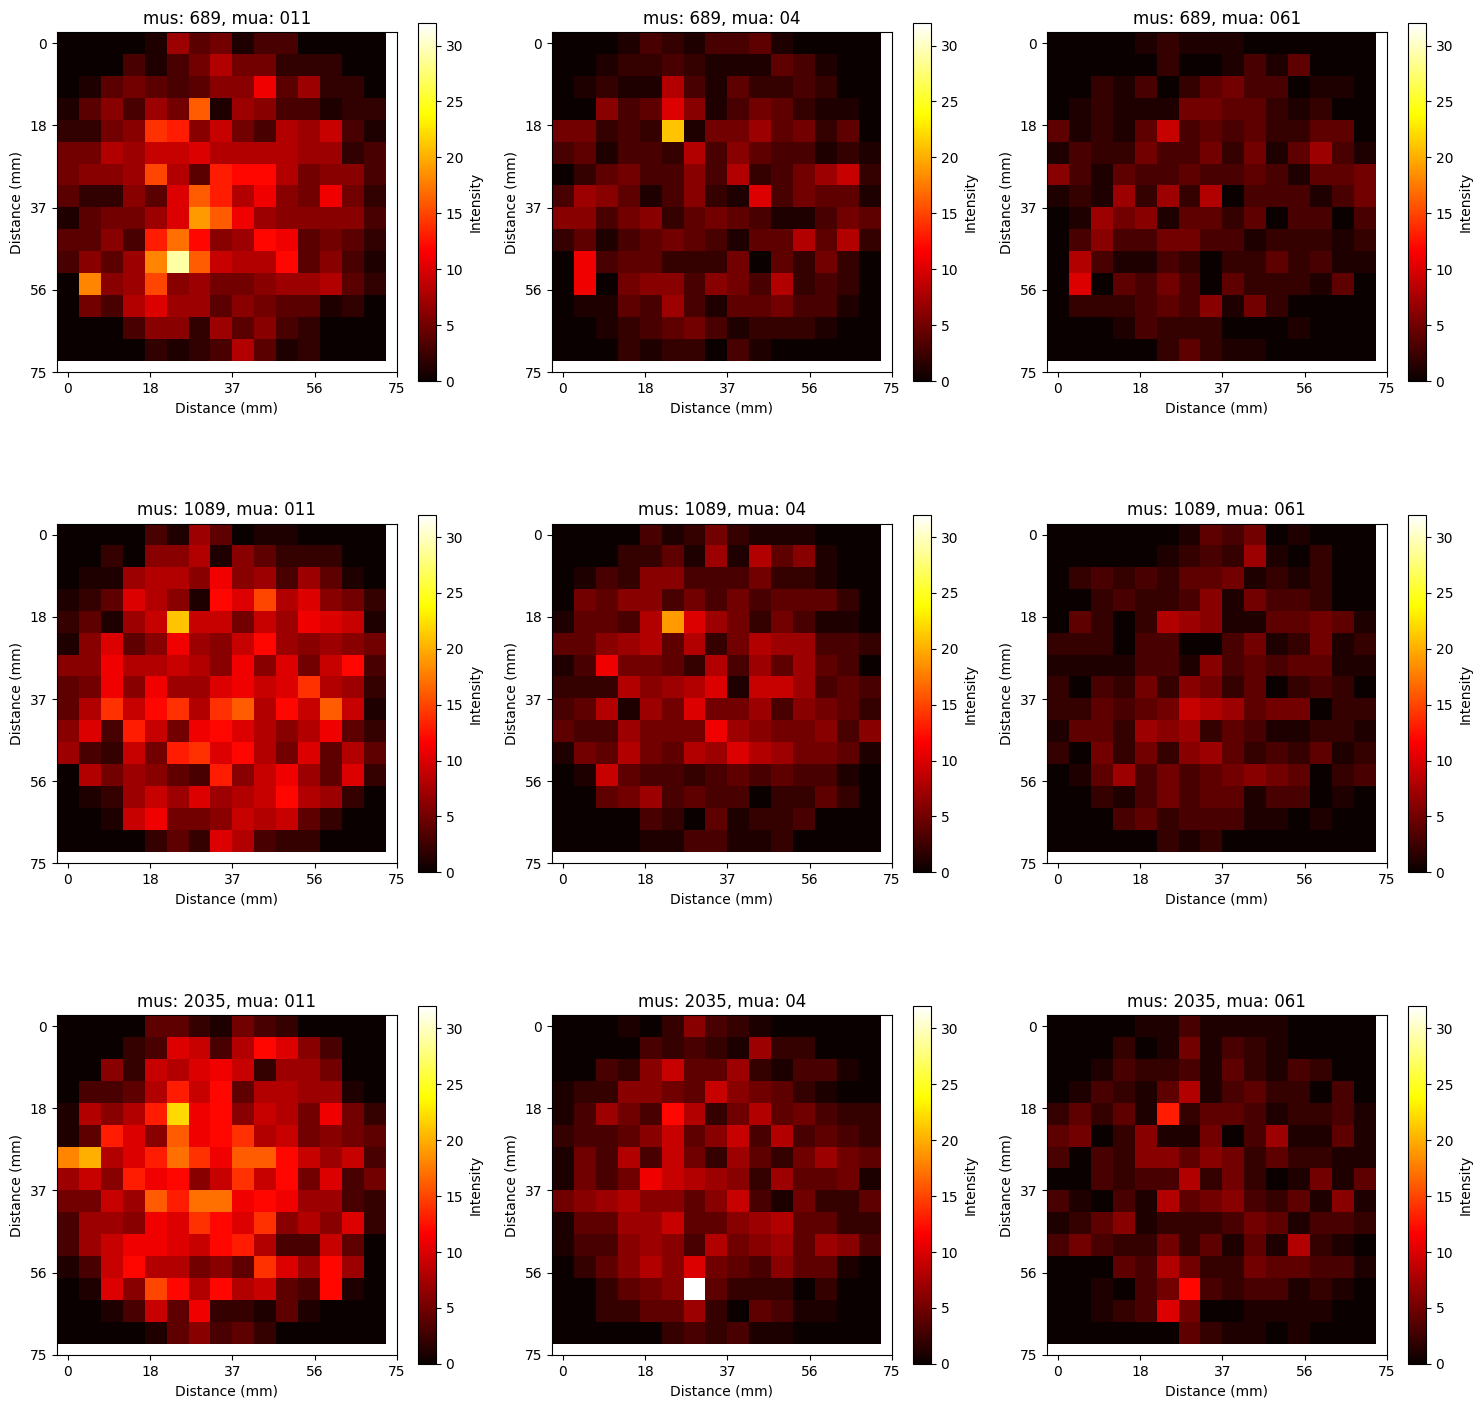

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to load saved images
def load_images(image_folder):
    images = []
    for filename in os.listdir(image_folder):
        if filename.endswith(".tif"):
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path)
            
            # Extracting mus and mua from filename
            mus_mua = filename.split("_mus_")[-1].split("_mua_")
            mus = mus_mua[0]
            mua = mus_mua[1].split(".tif")[0]
            images.append((mus, mua, np.array(image)))
    return images

# Load saved images
image_folder = '/Applications/topas/OpticalPhantomExperiment/OutputCherenkovImages/'
images = load_images(image_folder)

# Sort images based on custom criteria
images.sort(key=lambda x: (int(x[1]), int(x[0])))

# Get the minimum and maximum values of histograms across all images
min_value = min(np.min(image[2]) for image in images)
max_value = max(np.max(image[2]) for image in images) 


# Create a 3x3 montage plot
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Set the distance for each box (assuming each pixel represents 5 mm)
distance = 5  # in mm

# Reorder images so that mua_011 is in the first column, mua_04 is in the second column, and mua_061 is in the third column
images_reordered = [images[i] for i in [3, 0, 6,
                                         4, 1, 7, 
                                         5, 2, 8]]

# Plot each image with labels and color bar
for (mus, mua, image), ax in zip(images_reordered, axes.flat):
    im = ax.imshow(image, cmap='hot', vmin=min_value, vmax=max_value)
    ax.set_title(f"mus: {mus}, mua: {mua}")  # Set title with mus and mua values
    ax.set_xlabel('Distance (mm)')
    ax.set_ylabel('Distance (mm)')
    ax.set_xticks(np.linspace(0, image.shape[1], 5))  # Adjusted tick locations
    ax.set_yticks(np.linspace(0, image.shape[0], 5))  # Adjusted tick locations
    ax.set_xticklabels(np.linspace(0, image.shape[1] * distance, 5).astype(int))
    ax.set_yticklabels(np.linspace(0, image.shape[0] * distance, 5).astype(int))
    # Add a colorbar to each subplot
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75)
    cbar.set_label('Intensity')

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('3x3_montage.png')

# Show the plot
plt.show()





In [120]:

# NEED TO SIMULATE CAMERA HERE
# Add in efficiency, convolution kernel, and cosine effect (angular correction)

# Define your camera's intrinsic and extrinsic properties
intrinsic_params = {"param1": value1, "param2": value2}  # Placeholder values
extrinsic_params = {"param1": value1, "param2": value2}  # Placeholder values

# Simulate the camera recording the photons
camera_image = simulate_camera(histogram, intrinsic_params, extrinsic_params)

# Display the camera image
plt.imshow(camera_image, cmap='hot')
plt.colorbar()
plt.title("Simulated Camera Image")
plt.show()


NameError: name 'value1' is not defined